# Paper - Example 2

## Initialize

In [1]:
# Import the pyKasso and numpy packages
import pykasso as pk
import numpy as np

# Create a pyKasso application
app = pk.pykasso()

# Declare the grid parameters
grid_parameters = {
    'x0': 0,
    'y0': 0,
    'z0': 0,
    'nx': 100,
    'ny': 100,
    'nz': 50,
    'dx': 10,
    'dy': 10,
    'dz': 10,
}

# Declare the project parameters
app.new_project(project_name='example_02', grid_parameters=grid_parameters)
nx, ny, nz = app.project.grid.shape
app.visualizer.notebook = True
extent = app.project.grid.extent
imshow_options = {'extent': extent}

### Bedrock

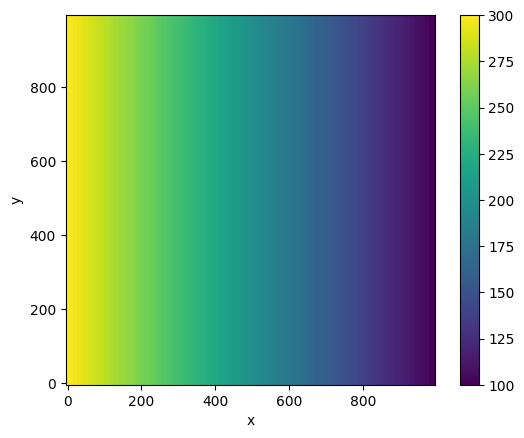

In [2]:
# Construct the bedrock elevation
bedrock = np.linspace(300, 100, nx)
bedrock = np.repeat(bedrock[:, np.newaxis], ny, axis=1)
f01 = app.visualizer.mpl_plot_array_2D(bedrock, imshow_options=imshow_options)
f01.fig.savefig('fig/example_02_bedrock')

### Water level

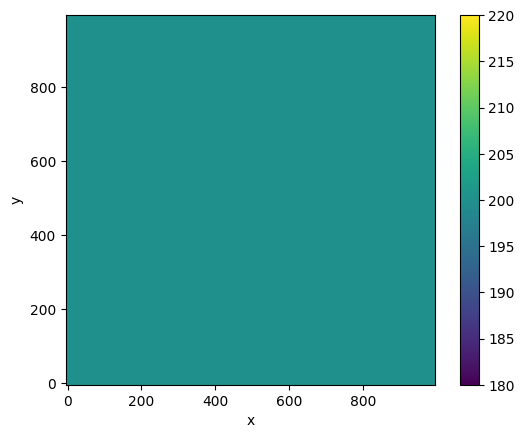

In [3]:
# Construct the water level
grid_shape = app.project.grid.shape[:2]
water_level = np.full(grid_shape, 200)
f02 = app.visualizer.mpl_plot_array_2D(water_level, imshow_options=imshow_options)
f02.fig.savefig('fig/example_02_water_level')

### Set the model

In [4]:
# Declare the model parameters
model_parameters = {
    'sks' : {
        'seed' : 1
    },
    'domain' : {
        'bedrock' : bedrock,
        'water_level' : water_level
    },
    'outlets' : {
        'seed' : 2,
        'number' : 1,
        'importance': [1],
    },
    'inlets' : {
        'seed' : 1,
        'number': 10,
        'importance': [1],
        'per_outlet': [1],
    }
}

## Compute

In [5]:
# Compute 1 simulation with isotropic fast marching algortihm
model_parameters['sks']['algorithm'] = 'Isotropic3'
app.model.generate(model_parameters=model_parameters)

# Compute 1 simulation with anisotropic fast marching algortihm
model_parameters['sks']['algorithm'] = 'Riemann3'
model_parameters['sks']['mode'] = 'D'
app.model.generate(model_parameters=model_parameters)

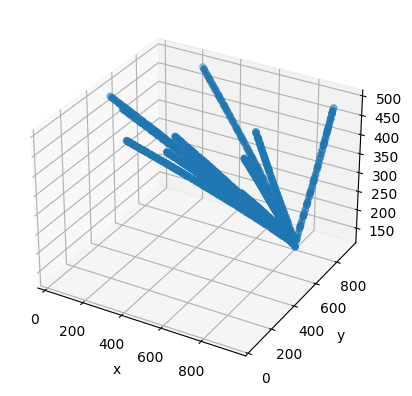

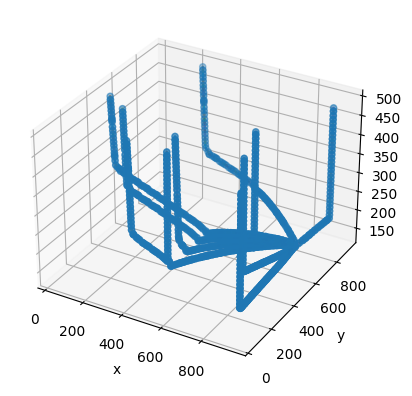

In [6]:
# Plot the simulated karstic networks
f03 = app.visualizer.mpl_plot_karstic_network(n_sim=0)
f03.fig.savefig('fig/example_02_isotropic')

f04 = app.visualizer.mpl_plot_karstic_network(n_sim=1)
f04.fig.savefig('fig/example_02_anisotropic')

In [10]:
app.visualizer.notebook = True

settings = {
    'ghost_values': [0],
    'surfaces_options' : {
        'bedrock' : {'opacity':1, 'cmap': 'copper'},
        'water_level' : {},
    },
}
last_simulations = app.project.get_last_simulations(2)
app.visualizer.pv_show(simulations=last_simulations,
                       features=['karst'],
                       settings=settings,
                       savefig=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

c:\Users\franc\OneDrive\Desktop\pykasso\pykasso\.venv\lib\site-packages\pyvista\plotting\plotting.py:6138: UserWarning: 
Set `jupyter_backend` backend to `"none"` to take a screenshot within a notebook environment.
  warnings.warn(


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)